In [18]:
import os
from subprocess import Popen, PIPE
import numpy as np
import matplotlib.pyplot as plt

#Hugo code
import Datasets
import Utility
import e7_tools

In [2]:
norm_sinograms,norm_sino_paths = Datasets.KEX_normalized_sinograms()

In [3]:
sinograms, sino_paths = Datasets.KEX_sinograms()

C:\Users\petct\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


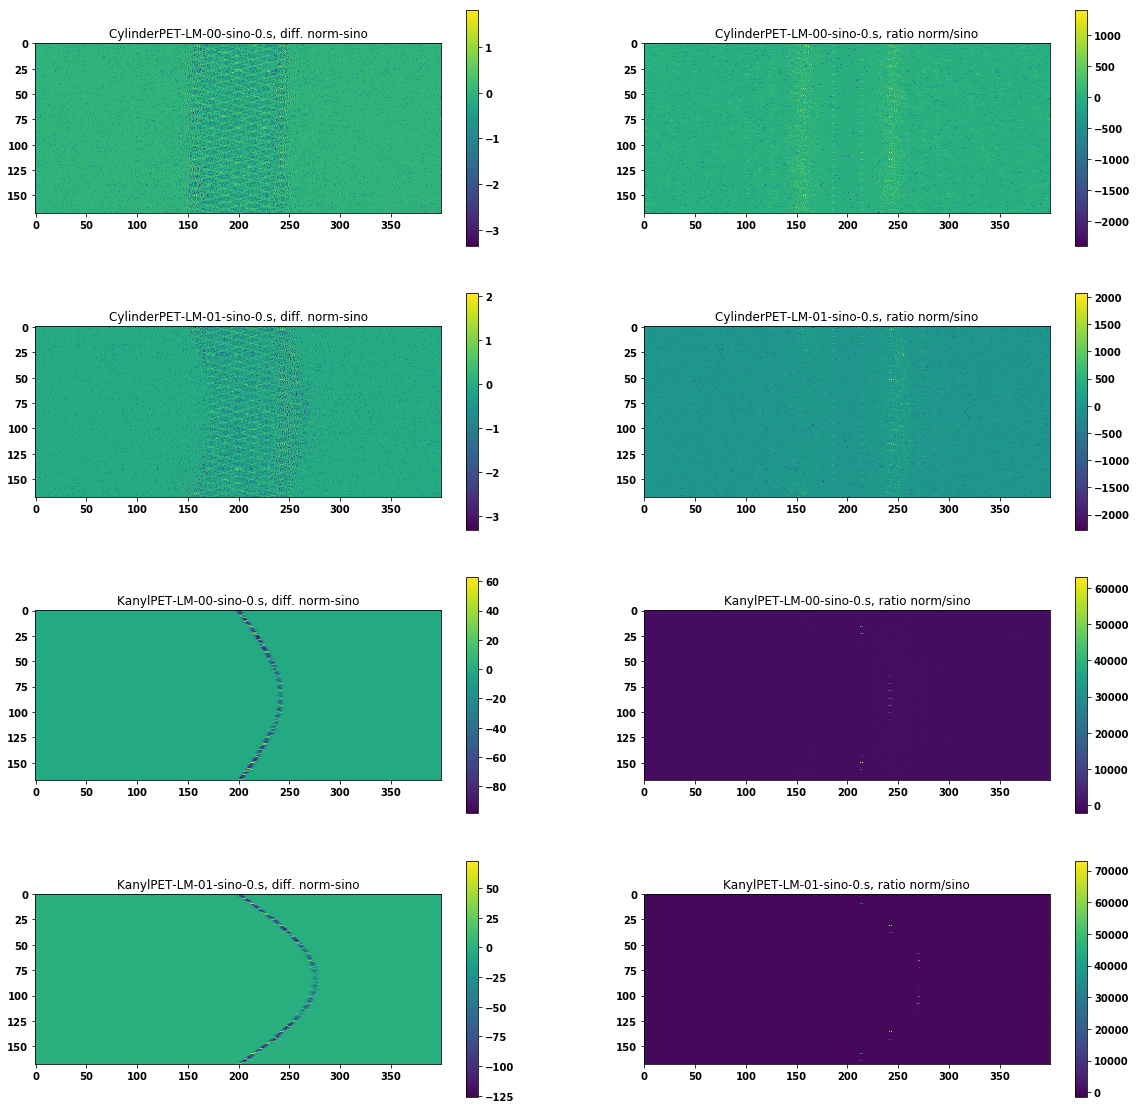

In [5]:
#ratio and difference
#sum away tof

mi = 50
plt.figure(figsize=(20,20))
for data_number, sino in enumerate(sinograms):
    sino_str = sino_paths[data_number].split('/')[-1]
    sino_2d = np.sum(sino[:-1,mi],axis=0)
    norm_sino_2d =  np.sum(norm_sinograms[data_number][:,mi], axis=0)
    diff = norm_sino_2d-sino_2d
    ratio = norm_sino_2d / (sino_2d+1e-3)
    results = [diff, ratio]
    result_strings = ["diff. norm-sino", "ratio norm/sino"]
    for k, img in enumerate(results):
        plt.subplot(len(sinograms), len(results), data_number*len(results) + k+1)
        plt.imshow(img)
        plt.title(sino_str + ", " + result_strings[k] )
        plt.colorbar()
plt.show()

In [11]:
#create a fake sinogram, save it, normalize it, and look at the result
fake_sinogram = np.ones(np.prod(Utility.HISTOGRAM_SHAPE), dtype=np.ushort)
fake_sinogram_no_delays = np.ones(Utility.HISTOGRAM_SHAPE, dtype=np.ushort)
fake_sinogram_no_delays[13] = 0

test_sinograms = [fake_sinogram, fake_sinogram_no_delays.flatten()]
names = ["fake_sinogram", "fake_sinogram_no_delays"]
destination_folder = r"C:/Users/petct/Desktop/Hugo/Code/PythonMEX/fake_sinograms/"
fake_sino_paths = []
for k,name_string in enumerate(names):
    output_path = destination_folder + name_string + ".s"
    fake_sino_paths.append(output_path)
    with open(output_path, 'wb') as file:
        #fast
        file.write(test_sinograms[k])

In [17]:
#verify
targets = [np.prod(Utility.HISTOGRAM_SHAPE), np.prod(Utility.HISTOGRAM_SHAPE_NO_DELAYS)]
error_count = 0
    
for k,input_path in enumerate(fake_sino_paths):
    with open(input_path, 'rb') as file:
        sinogram_1D = np.fromfile(file, dtype=np.ushort)
    sino_sum = np.sum(sinogram_1D)
    if sino_sum != targets[k]:
        error_count +=1
        
if error_count > 0:
    print("there were ", error_count, "errors")
else:
    print("test passed")

print("done")

test passed
done


In [91]:
#normalize
norm_sino_output_paths = []
norm_path = r"C:/Users/petct/Desktop/CylinderPET-Converted/CylinderPET-norm.n.hdr"
for k, path in enumerate(fake_sino_paths):
    #subheader is not sufficient, but main header with subheader works
    path = path.replace(".s", ".mhdr")
    norm_sino_path = path.replace(".",'-norm.')
    print("norm path", norm_sino_path)
    norm_sino_output_paths.append(norm_sino_path)
    command_string = "e7_recon.exe " 
    command_string += " -e " + path
    command_string += " --oe " + norm_sino_path
    command_string += " -n " + norm_path
    command_string += " --gf"
    command_string += " --tof --force "
    #use model instead of header file ...e7 did not save anything
    #command_string += " --model 1104"
    command_string += " -l 0"
    r= e7_tools.run_e7_tool(command_string=command_string)
    print("return code", r)

print("done")

norm path C:/Users/petct/Desktop/Hugo/Code/PythonMEX/fake_sinograms/fake_sinogram-norm.mhdr
stdout
 b''
stderr
 b''
return code 0
norm path C:/Users/petct/Desktop/Hugo/Code/PythonMEX/fake_sinograms/fake_sinogram_no_delays-norm.mhdr
stdout
 b''
stderr
 b''
return code 0
done


In [92]:
fake_normalized_sinograms = []
for sino_mhdr_path in norm_sino_output_paths:
    path = sino_mhdr_path.replace(".mhdr", "_00.s")
    print("path", path)
    with open(path, 'rb') as file:
        sinogram_1D = np.fromfile(file, dtype=np.float32)
    fake_normalized_sinograms.append(np.reshape(sinogram_1D, Utility.HISTOGRAM_SHAPE_NO_DELAYS, order='C'))    

path C:/Users/petct/Desktop/Hugo/Code/PythonMEX/fake_sinograms/fake_sinogram-norm_00.s
path C:/Users/petct/Desktop/Hugo/Code/PythonMEX/fake_sinograms/fake_sinogram_no_delays-norm_00.s


minimal sinogram value 0.011279151


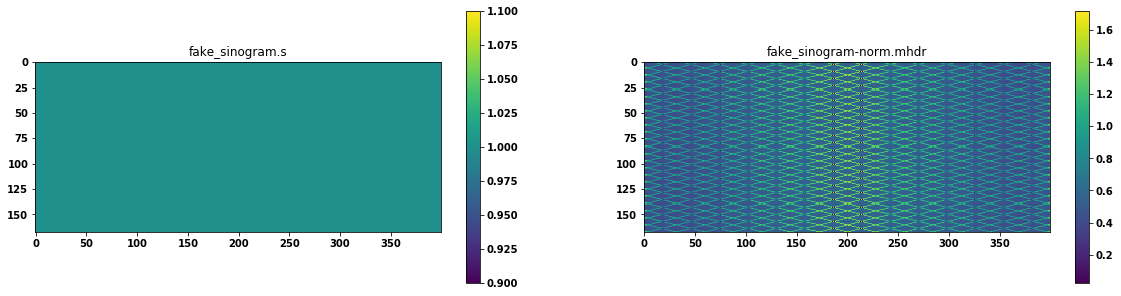

minimal sinogram value 0.01221908


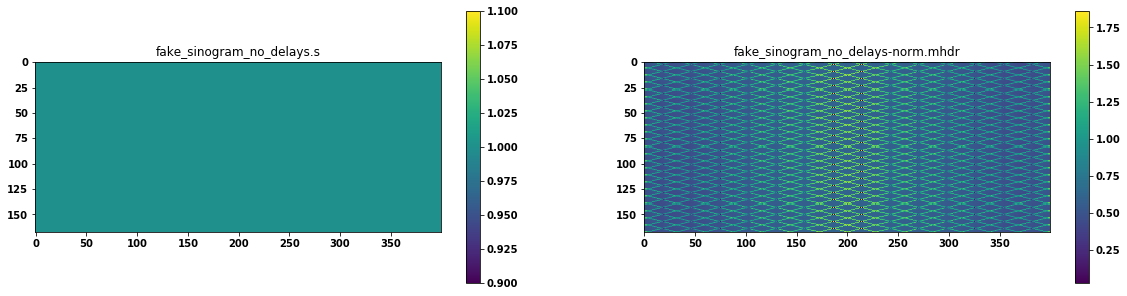

In [93]:
#look at tofbin 0
#look at one mi
mi = 50
for k,fake_norm_sino in enumerate(fake_normalized_sinograms):
    sinogs = [np.reshape(test_sinograms[k], Utility.HISTOGRAM_SHAPE), fake_norm_sino]
    paths = [fake_sino_paths[k], norm_sino_output_paths[k]]
    plt.figure(figsize=(20,5))
    print("minimal sinogram value", np.min(fake_norm_sino))
    for g in range(2):
        plt.subplot(1,2,g+1)
        plt.imshow(sinogs[g][0,mi])
        plt.colorbar()
        plt.title(paths[g].split('/')[-1])
    plt.show()

In [ ]:
#look for minimum values
for 

In [44]:
# look at normalization matrix for comparison
norm3d, norm_paths =Datasets.KEX_intermediate_files(only_norm=True)

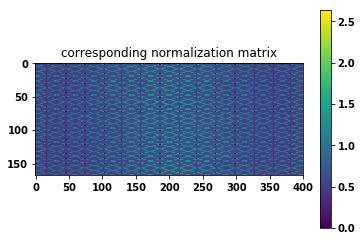

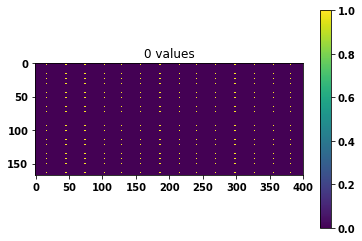

minimal norm. matrix value 0.0


In [90]:
norm_matrix = norm3d[1][mi]
plt.imshow(norm_matrix)
plt.title("corresponding normalization matrix")
plt.colorbar()
plt.show()

plt.imshow(np.array(norm_matrix == 0, dtype=int))
plt.title("0 values")
plt.colorbar()
plt.show()
print("minimal norm. matrix value", np.min(norm_matrix))

elements less than 5.933291912078857 count 9674


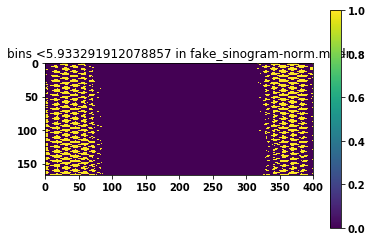

elements less than 6.344398498535156 count 8074


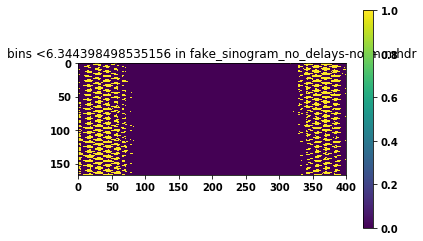

In [81]:
#look at zeros
#sum over tof axis
#look at one mi
mi = 50
for k,fake_norm_sino in enumerate(fake_normalized_sinograms):
    tof_sum = np.sum(fake_norm_sino, axis=0)[mi]
    bound = np.min(tof_sum) + 1
    #print(tof_sum < bound)
    less_than = np.array(tof_sum < bound, dtype=int)
    print("elements less than",bound,"count", np.sum(less_than))
    plt.imshow(less_than)
    plt.title("bins <" +str(bound) + " in "+ norm_sino_output_paths[k].split('/')[-1].split('_00')[0])
    plt.colorbar()
    plt.show()